In [18]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm
import lightgbm as lgb
import warnings 

In [19]:
plt.style.use('ggplot')
plt.rc('font', family = 'malgun gothic')
warnings.filterwarnings(action = 'ignore')

In [20]:
df = pd.read_csv('C:/Users/whileduck/Desktop/kaggle/data.csv')
origin = pd.read_csv('C:/Users/whileduck/Desktop/kaggle/origin_data.csv')
sub = pd.read_csv('C:/Users/whileduck/Desktop/kaggle/sample_submission.csv')

In [21]:
df = pd.concat([df,origin])
df

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8
...,...,...,...,...,...,...,...,...,...,...
1860,1861,Richenderfer,plate,1.01,1500.0,-0.0218,15.0,120.0,10.0,9.4
1861,1862,Richenderfer,plate,1.01,1500.0,-0.0434,15.0,120.0,10.0,10.4
1862,1863,Richenderfer,plate,1.01,2000.0,-0.0109,15.0,120.0,10.0,10.8
1863,1864,Richenderfer,plate,1.01,2000.0,-0.0218,15.0,120.0,10.0,10.9


The dataset for this competition (both train and test) was generated from a deep learning model trained on the Predicting Critical Heat Flux dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

Files

    data.csv - the competition dataset; your objective is to impute the missing values of the feature x_e_out [-] (equilibrium quality)
    sample_submission.csv - a sample submission file in the correct format

### Evaluations : RMSE

# 이번 Playground의 주 목적
- 데이터프레임에 있는 다양한 결측값을 어떻게 채울 것이냐 
- 타겟값은 x_e_out 
- 컬럼들의 특수 기호를 어떻게 제거하여 사용에 용이하게 할 것이냐 

# 메모리 용량 줄이기 

In [22]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [23]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 2.81 MB
Memory usage after optimization is: 1.28 MB
Decreased by 54.5%


# 행 별 갤측값 갯수 

In [24]:
max_na = len(df.columns)

print(f'행 별 결측값 갯수의 범위 : 0 ~ {max_na}')

행 별 결측값 갯수의 범위 : 0 ~ 10


Text(0.5, 0, '결측값 갯수')

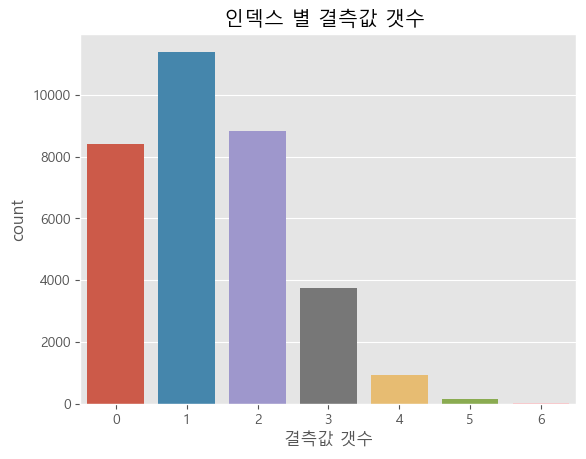

In [25]:
na_df = pd.DataFrame(df.isna().sum(axis = 1)).reset_index() # 인덱스 별 결측값 갯수 

sns.countplot(data = na_df,
                x = 0)
plt.title('인덱스 별 결측값 갯수 ')
plt.xlabel('결측값 갯수')

* 결측치를 채워야 하는 인덱스들은 총 24000 개 정도가 된다. 예측을 위해 

* 예전에는 결측치를 모두 평균, 중앙값, 랜덤한 난수 등으로 채워왔으나 머신러닝을 통해 보간하는 방법도 있다.

# Columns 명 변경하기 

In [26]:
df.columns = df.columns.map(lambda x: x.split('[')[0].strip())

df.columns

Index(['id', 'author', 'geometry', 'pressure', 'mass_flux', 'x_e_out', 'D_e',
       'D_h', 'length', 'chf_exp'],
      dtype='object')

In [27]:
df = df.drop('id',axis =1)

In [28]:
submission_obj = df['x_e_out']
df = df.drop('x_e_out',axis = 1)

In [29]:
missing_value = [col for col in df.columns if df[col].isna().sum() > 0]
missing_value

['author', 'geometry', 'pressure', 'mass_flux', 'D_e', 'D_h', 'length']

In [30]:
cat_cols = missing_value[:2]
num_cols = missing_value[2:]

In [31]:
for col in cat_cols:
    
    cond = df[col].isna()
    
    train = df.loc[~cond]
    test = df.loc[cond]
    
    idx = test.index
    
    params = {'objective':'multiclass',
            'num_class': train[col].nunique() + 1,
            'num_boost_round':100,
            'verbose':-1}
    
    label = {v:k for k,v in enumerate(train[col].unique())}
    reverse_label = {k:v for k,v in enumerate(train[col].unique())}
    
    x_train = pd.get_dummies(train.drop(col,axis = 1))
    y_train = train[col].map(label)
    
    
    data = lgb.Dataset(data = x_train,
                label = y_train)
    
    model = lgb.train(params, data)
    
    pred_proba = model.predict(pd.get_dummies(test))
    
    pred = pred_proba.argmax(axis = 1)
    
    df.loc[cond,col] = pred
    df.loc[cond,col] = df.loc[cond,col].map(reverse_label)


In [32]:
for col in num_cols:

        cond = df[col].isna()
        
        train = pd.get_dummies(df[~cond])
        test = pd.get_dummies(df[cond])
        
        x_train = train.drop(col,axis = 1)
        y_train = train[col]
        
        params = {'objective':'regression',
                'num_boost_round':100,
                'metric':'neg_root_mean_squared_error',
                'verbose':-1,
                }
        
        
        data = lgb.Dataset(data = x_train,
                        label = y_train)
        
        model = lgb.train(params,data)
        
        df.loc[cond,col] = model.predict(test.drop(col,axis = 1))

In [35]:
df

,author,geometry,pressure,mass_flux,D_e,D_h,length,chf_exp
0,Thompson,tube,7.000000,3770.0,10.741596,10.796875,432.0,3.599609
1,Thompson,tube,8.231439,6048.0,10.296875,10.296875,762.0,6.199219
2,Thompson,tube,13.789062,2034.0,7.699219,7.699219,457.0,2.500000
3,Beus,annulus,13.789062,3680.0,5.601562,15.203125,2134.0,3.000000
4,Weatherhead,tube,13.789062,686.0,11.101562,11.101562,457.0,2.800781
...,...,...,...,...,...,...,...,...
1860,Richenderfer,plate,1.009766,1500.0,15.000000,120.000000,10.0,9.398438
1861,Richenderfer,plate,1.009766,1500.0,15.000000,120.000000,10.0,10.398438
1862,Richenderfer,plate,1.009766,2000.0,15.000000,120.000000,10.0,10.796875
1863,Richenderfer,plate,1.009766,2000.0,15.000000,120.000000,10.0,10.898438


In [37]:
df['label'] = submission_obj
df

,author,geometry,pressure,mass_flux,D_e,D_h,length,chf_exp,label
0,Thompson,tube,7.000000,3770.0,10.741596,10.796875,432.0,3.599609,0.175415
1,Thompson,tube,8.231439,6048.0,10.296875,10.296875,762.0,6.199219,-0.041595
2,Thompson,tube,13.789062,2034.0,7.699219,7.699219,457.0,2.500000,0.033508
3,Beus,annulus,13.789062,3680.0,5.601562,15.203125,2134.0,3.000000,-0.027893
4,Weatherhead,tube,13.789062,686.0,11.101562,11.101562,457.0,2.800781,NaN
...,...,...,...,...,...,...,...,...,...
1860,Richenderfer,plate,1.009766,1500.0,15.000000,120.000000,10.0,9.398438,-0.021805
1861,Richenderfer,plate,1.009766,1500.0,15.000000,120.000000,10.0,10.398438,-0.043396
1862,Richenderfer,plate,1.009766,2000.0,15.000000,120.000000,10.0,10.796875,-0.010902
1863,Richenderfer,plate,1.009766,2000.0,15.000000,120.000000,10.0,10.898438,-0.021805


In [43]:
cond = df['label'].isna()

train = pd.get_dummies(df[~cond])
test = pd.get_dummies(df[cond])

x_train = train.drop('label',axis = 1)
y_train = train['label']

x_test = test.drop('label',axis = 1)

data = lgb.Dataset(data = x_train,
            label = y_train)

model = lgb.train(params, data)

pred = model.predict(test.drop('label',axis = 1))

In [46]:
sub['x_e_out [-]'] = pred

In [48]:
sub.to_csv('LGBImputer.csv',index = False)